<a href="https://colab.research.google.com/github/RawanKhaled20/Unsupervised_Seeds_Clustering/blob/main/Unsupervised_learning_using_cfuzzy_and_cfuzzyentropy2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing dataset of wheat seeds**

In [1]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
!mkdir -p ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d jmcaro/wheat-seedsuci

  0% 0.00/3.60k [00:00<?, ?B/s]
100% 3.60k/3.60k [00:00<00:00, 2.50MB/s]


In [6]:
! unzip wheat-seedsuci.zip

Archive:  wheat-seedsuci.zip
  inflating: seeds.csv               


In [7]:
!pip install scikit-fuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894077 sha256=2e0269e20b47869276c3b547e67a6954e656035f89913f9b694a73438a67b7d1
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


**Import necessary libraries**

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial import distance_matrix
from scipy.special import comb
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import skfuzzy as fuzz
from sklearn.metrics import silhouette_score
# Import Fuzzy C-means (FCM)
from skfuzzy.cluster import cmeans ,cmeans_predict
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial import distance_matrix
from itertools import combinations
from scipy.spatial.distance import cdist

# **Data Preprocessing**

In [9]:
import pandas as pd

df=pd.read_csv('seeds.csv')
print(df.shape)

(199, 8)


In [10]:
df.info()   # No nan values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             199 non-null    float64
 1   Perimeter        199 non-null    float64
 2   Compactness      199 non-null    float64
 3   Kernel.Length    199 non-null    float64
 4   Kernel.Width     199 non-null    float64
 5   Asymmetry.Coeff  199 non-null    float64
 6   Kernel.Groove    199 non-null    float64
 7   Type             199 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


In [11]:
df.head()   # No categorical values

,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove,Type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


**Detect outliers using distplot and boxplot visualization**

<ipython-input-12-5eec96501cde>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True)   # Mostly gaussian distribution
<ipython-input-12-5eec96501cde>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True)   # Mostly gaussian distribution
<ipython-input-12-5eec96501cde

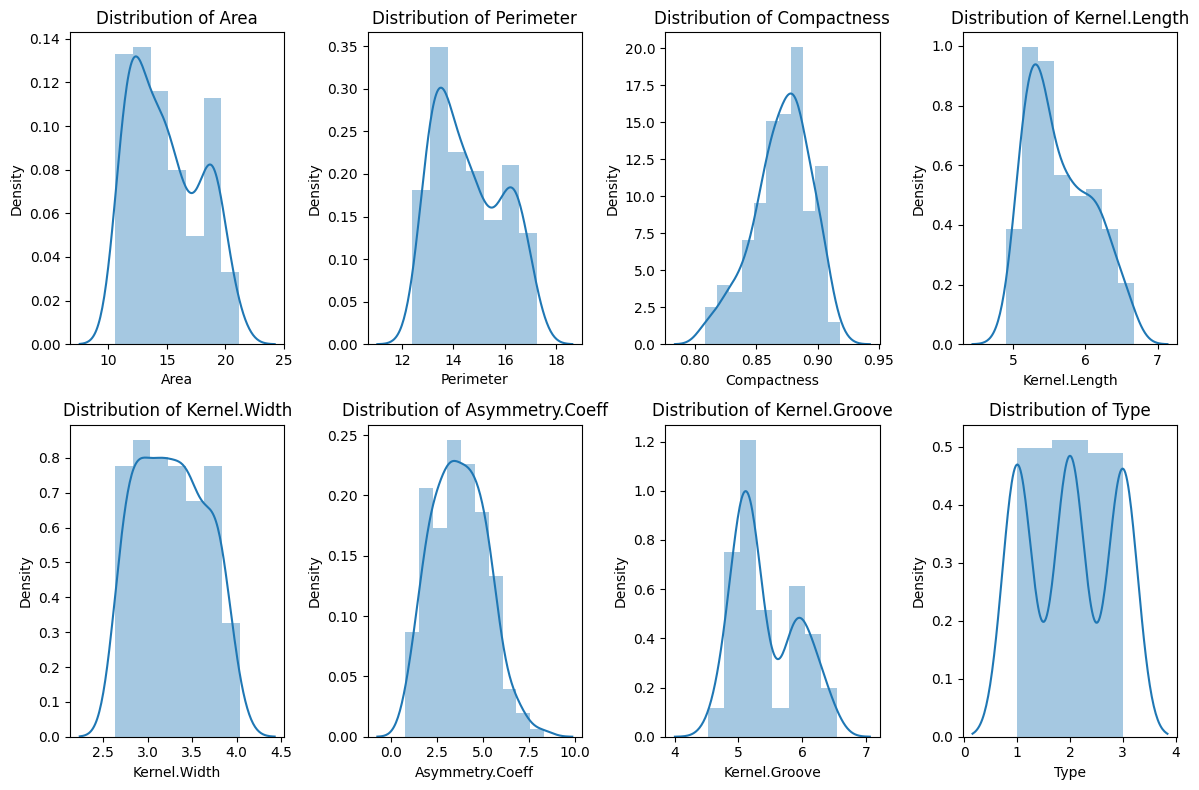

In [12]:
# Visualize distribution of each feature with distplots
plt.figure(figsize=(12, 8))
for i, col in enumerate(df.columns):
    plt.subplot(2, 4, i+1)
    sns.distplot(df[col], kde=True)   # Mostly gaussian distribution
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

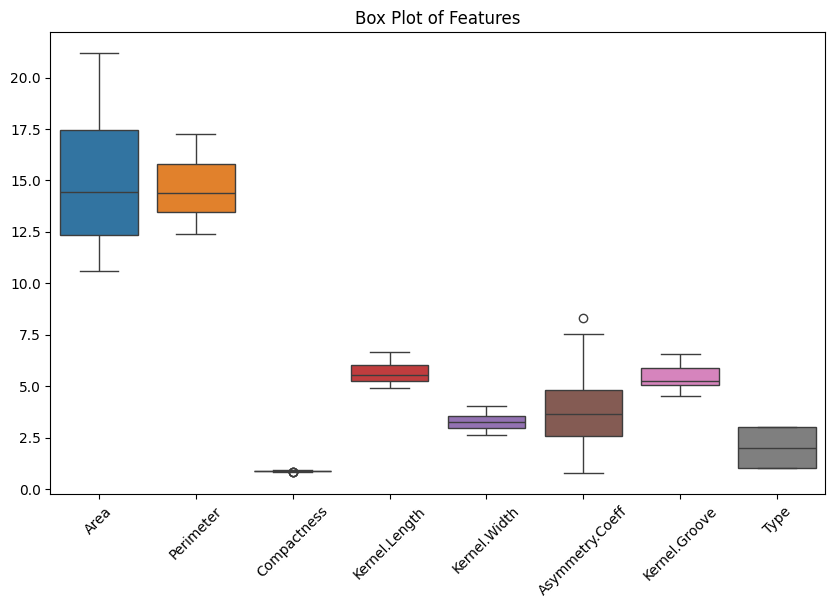

In [13]:
# Visualize outliers with box plots
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.title('Box Plot of Features')
plt.xticks(rotation=45)
plt.show()

Almost no outliers found

# **Correlation heatmap visualization**
 Get the correlation matrix to see the correlation between the features so that highly correlated features are redundant and understand the importance of applying PCA in that case

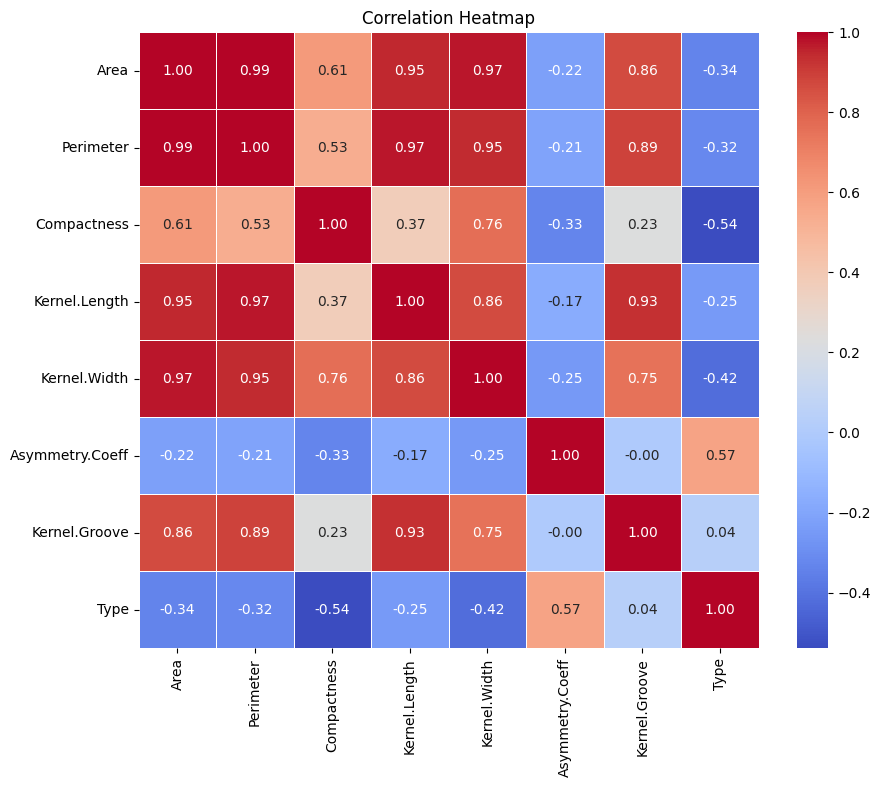

In [14]:
# Calculate correlation matrix for reduntant features removal
corr_matrix = df.corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Alot of features are very higly correlated

**Remove the target column**

In [15]:
df_new = df.drop(columns=['Type'])

# **Applying PCA**
Using elbow method to get best component

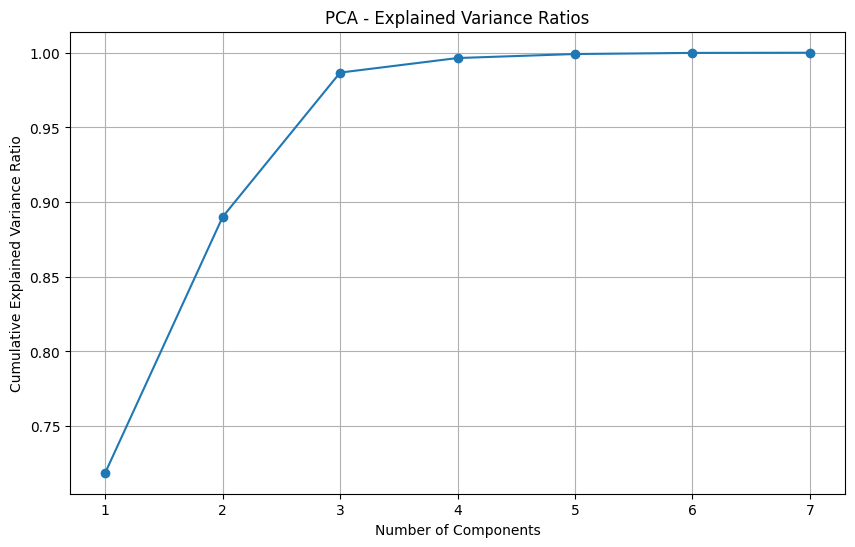

In [16]:
# Standard Scaling
scaler = StandardScaler()
X = scaler.fit_transform(df_new)

# Create a list to store explained variance ratios
explained_variance_ratios = []

# Try different numbers of components
for n_components in range(1, min(df_new.shape)+1):
    # Initialize PCA with the current number of components
    pca = PCA(n_components=n_components)

    # Fit PCA to the data
    pca.fit(X)

    # Compute cumulative explained variance ratio
    explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)

    # Store the cumulative explained variance ratio for the current number of components
    explained_variance_ratios.append(explained_variance_ratio_cumulative[-1])

# Plot explained variance ratios
plt.figure(figsize=(10, 6))
plt.plot(range(1, min(df_new.shape)+1), explained_variance_ratios, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA - Explained Variance Ratios')
plt.grid(True)
plt.show()

Using elbow method: As seen 5 is the best number of components as increasing more doesn't affect the explained variance in the data.

Using Compression and decompression of data

Number of Components: 1, Reconstruction Error: 0.28121340998832445


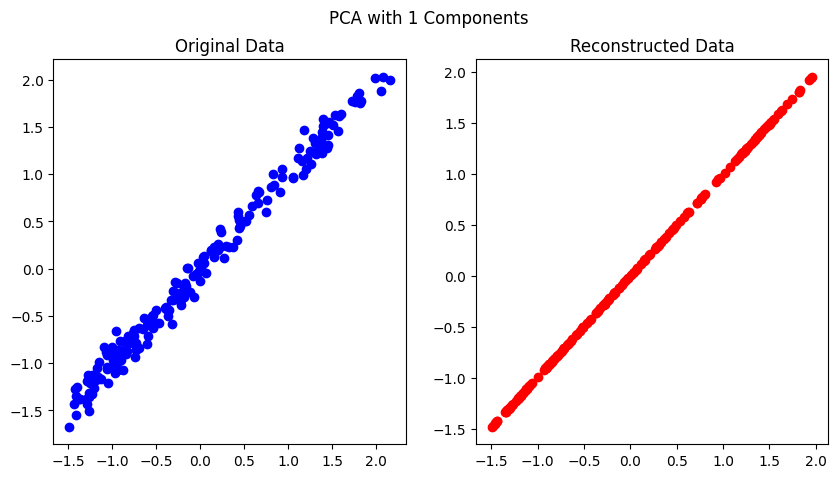

Number of Components: 2, Reconstruction Error: 0.10990853575123707


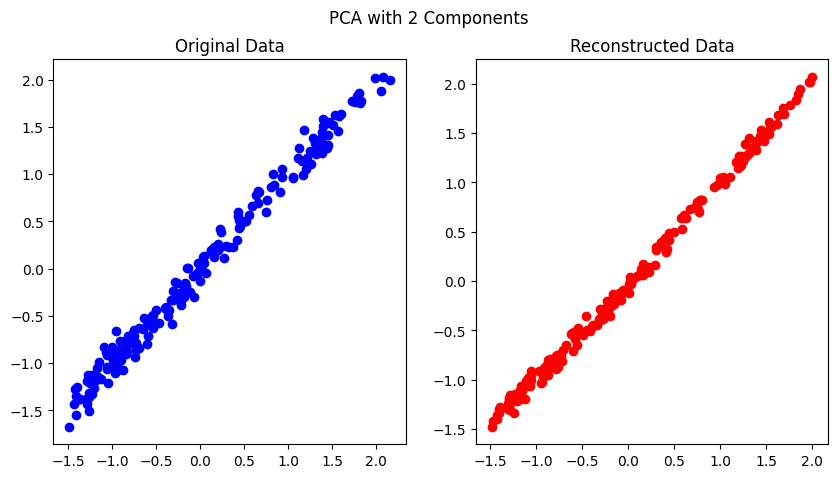

Number of Components: 3, Reconstruction Error: 0.013306202724099452


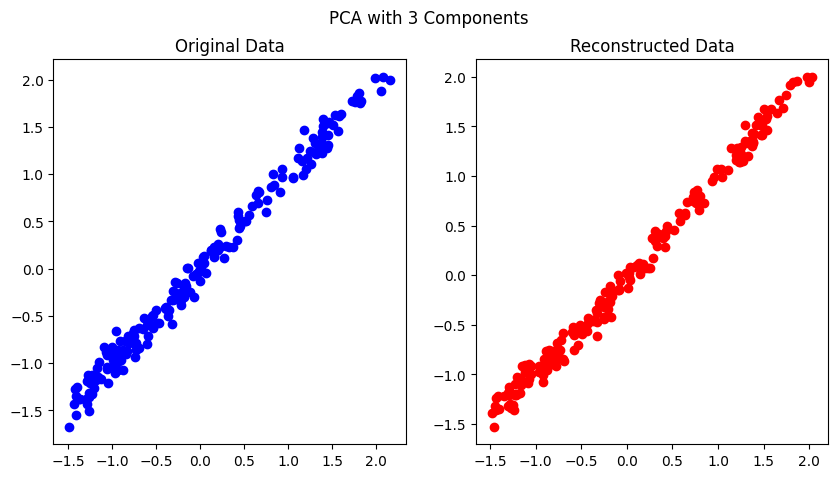

Number of Components: 4, Reconstruction Error: 0.0035628999667019694


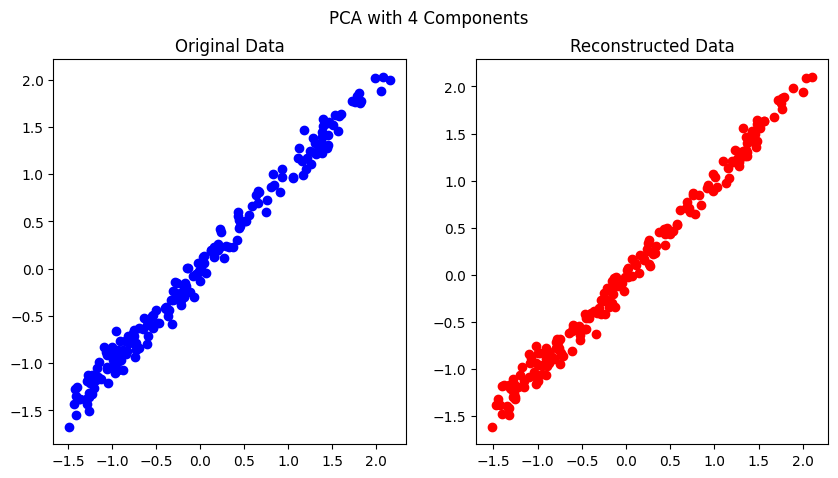

Number of Components: 5, Reconstruction Error: 0.0008754061970102798


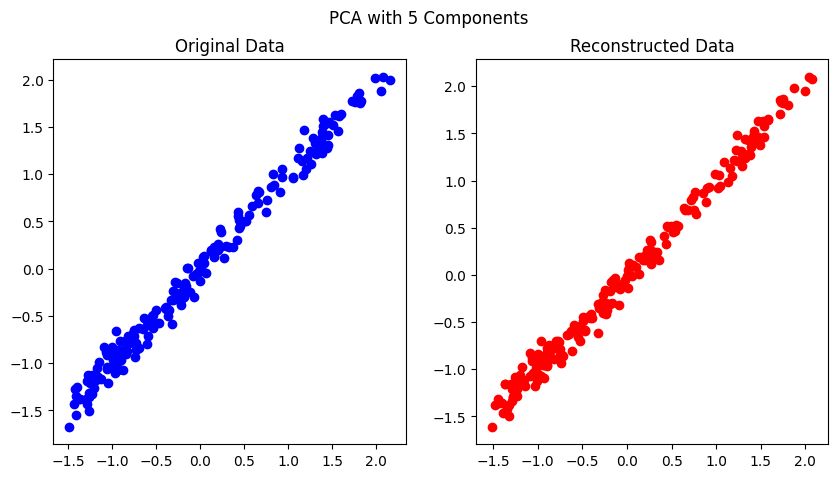

Number of Components: 6, Reconstruction Error: 0.00011603966387925942


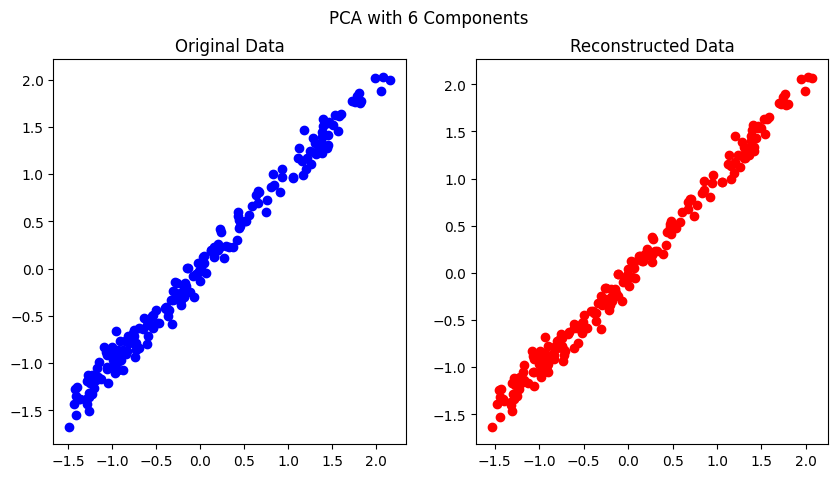

Number of Components: 7, Reconstruction Error: 1.5863305789817146e-31


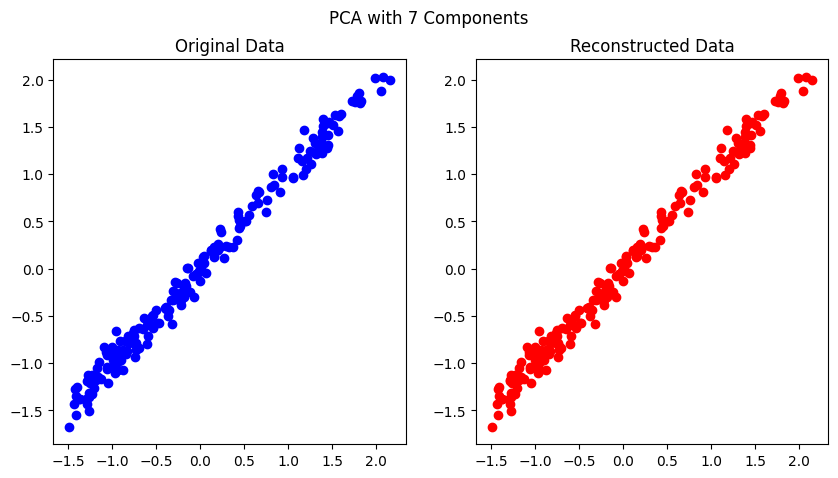

In [17]:
# Try different numbers of components
for n_components in range(1, min(df_new.shape)+1):
    # Initialize PCA with the current number of components
    pca = PCA(n_components=n_components)

    # Fit PCA to the data
    pca.fit(X)

    # Compress the data
    X_compressed = pca.transform(X)

    # Decompress the data
    X_decompressed = pca.inverse_transform(X_compressed)

    # Compute reconstruction error
    reconstruction_error = np.mean(np.square(X - X_decompressed))

    print(f"Number of Components: {n_components}, Reconstruction Error: {reconstruction_error}")

    # Plot the original and reconstructed data for visualization
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].scatter(X[:, 0], X[:, 1], c='b', label='Original Data')
    axes[0].set_title('Original Data')
    axes[1].scatter(X_decompressed[:, 0], X_decompressed[:, 1], c='r', label='Reconstructed Data')
    axes[1].set_title('Reconstructed Data')
    plt.suptitle(f'PCA with {n_components} Components')
    plt.show()

Using Construction/Deconstruction: As seen the error is decresing as we increase the number of components yet still at component 4 the data reconstructed starts to become very similar to the original yet will try capturing the point where the error doesn't change alot to be our optimal

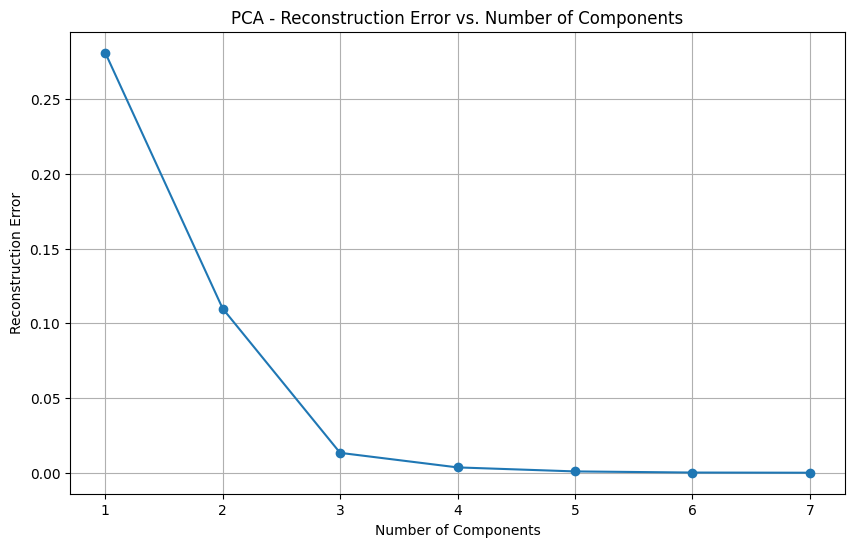

In [18]:
# Calculate reconstruction errors for different numbers of components to see where the error signifiacntly doesn't change
reconstruction_errors = []
for n_components in range(1, min(df_new.shape)+1):
    pca = PCA(n_components=n_components)
    pca.fit(X)
    X_decompressed = pca.inverse_transform(pca.transform(X))
    reconstruction_error = np.mean(np.square(X - X_decompressed))
    reconstruction_errors.append(reconstruction_error)

# Plot reconstruction errors
plt.figure(figsize=(10, 6))
plt.plot(range(1, min(df_new.shape)+1), reconstruction_errors, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('PCA - Reconstruction Error vs. Number of Components')
plt.grid(True)
plt.show()

As seen after plotting the reconstruction error we found that starting from 5 components it becomes very hard to distinguish the error but it was still a bit obvious to the eyes the difference between 5 and 6 so we will try both 5 and 6 components to see which one will have the optimal score

In [19]:
# Initialize PCA with 6 components for traget less dataset
pca1 = PCA(n_components=6)

# Fit PCA to the data
pca1.fit(X)

# Transform the original data to obtain the compressed representation
df_compressed1 = pca1.transform(X)

In [20]:
# Initialize PCA with 5 components for traget less dataset
pca2 = PCA(n_components=5)

# Fit PCA to the data
pca2.fit(X)

# Transform the original data to obtain the compressed representation
df_compressed2 = pca2.transform(X)

# **1. Fuzzy C-Means (FCM):**
FCM is a soft clustering algorithm where each data point belongs to every cluster with a certain degree of membership.

**Key Hyperparameters:**

**n_clusters:** Number of clusters to partition the data into.

**m:** Fuzziness parameter that controls the degree of fuzziness in cluster assignments. It determines the level of cluster overlap; higher values of m lead to fuzzier clusters.

**error:** Convergence criterion based on the maximum change in cluster centers.

**maxiter:** Maximum number of iterations.
# **2. Entropy-Based Fuzzy Clustering:**
Entropy-based fuzzy clustering aims to minimize the entropy of cluster memberships, leading to well-separated clusters with clear boundaries.

**Key Hyperparameters:**

**n_clusters:** Number of clusters to partition the data into.

**m:** Fuzziness parameter, similar to FCM.

**entropy:** Weighting parameter that controls the influence of entropy in the objective function. It balances the trade-off between minimizing entropy and maximizing cluster separation.

Now, let's apply both FCM on the original dataset, the pca applied dataset and a removed correlation dataset with different hyperparameter values:

In [21]:
# Define hyperparameter values to experiment with
n_clusters = 3
m_values = [1.1, 1.5, 2]  # Fuzziness parameter

# Perform Fuzzy C-Means (FCM)
for m in m_values:
    cntr_fcm, u_fcm, _, _, _, _, _ = cmeans(df_compressed1.T, n_clusters, m, error=0.005, maxiter=1000)

    # Evaluate clustering performance
    silhouette_fcm = silhouette_score(df_compressed1, np.argmax(u_fcm, axis=0))
    print(f"FCM (m={m}): Silhouette Score = {silhouette_fcm:.4f}")

FCM (m=1.1): Silhouette Score = 0.4040
FCM (m=1.5): Silhouette Score = 0.4009
FCM (m=2): Silhouette Score = 0.3997


In [22]:
# Define hyperparameter values to experiment with
n_clusters = 3
m_values = [1.1, 1.5, 2]  # Fuzziness parameter

# Perform Fuzzy C-Means (FCM)
for m in m_values:
    cntr_fcm, u_fcm, _, _, _, _, _ = cmeans(df_compressed2.T, n_clusters, m, error=0.005, maxiter=1000)

    # Evaluate clustering performance
    silhouette_fcm = silhouette_score(df_compressed2, np.argmax(u_fcm, axis=0))
    print(f"FCM (m={m}): Silhouette Score = {silhouette_fcm:.4f}")

FCM (m=1.1): Silhouette Score = 0.4046
FCM (m=1.5): Silhouette Score = 0.4016
FCM (m=2): Silhouette Score = 0.4004


From this result we can conclude that 5 components is the optimal choice

In [31]:
# Define hyperparameter values to experiment with
n_clusters = 3
m_values = [1.1, 1.5, 2]  # Fuzziness parameter

# Perform Fuzzy C-Means (FCM)
for m in m_values:
    cntr_fcm, u_fcm, _, _, _, _, _ = cmeans(X.T, n_clusters, m, error=0.005, maxiter=1000)

    # Evaluate clustering performance
    silhouette_fcm = silhouette_score(df_new, np.argmax(u_fcm, axis=0))
    print(f"FCM (m={m}): Silhouette Score = {silhouette_fcm:.4f}")

FCM (m=1.1): Silhouette Score = 0.4405
FCM (m=1.5): Silhouette Score = 0.4481
FCM (m=2): Silhouette Score = 0.4473


In [24]:
#Remove highly correlated features as they are redundant
# Drop 'perimeter', 'kernel length', and 'kernel width' columns
df_new2 = df_new.drop(['Perimeter', 'Kernel.Length', 'Kernel.Width'], axis=1)

In [32]:
# Standard Scaling
scaler = StandardScaler()
X2 = scaler.fit_transform(df_new2)

In [33]:
# Define hyperparameter values to experiment with
n_clusters = 3
m_values = [1.1, 1.5, 2]  # Fuzziness parameter

# Perform Fuzzy C-Means (FCM)
for m in m_values:
    cntr_fcm, u_fcm, _, _, _, _, _ = cmeans(X2.T, n_clusters, m, error=0.005, maxiter=1000)

    # Evaluate clustering performance
    silhouette_fcm = silhouette_score(df_new2, np.argmax(u_fcm, axis=0))
    print(f"FCM (m={m}): Silhouette Score = {silhouette_fcm:.4f}")

FCM (m=1.1): Silhouette Score = 0.4173
FCM (m=1.5): Silhouette Score = 0.4173
FCM (m=2): Silhouette Score = 0.4205


In [26]:
# Replace all occurrences of 1 with 0, 2 with 1, and 3 with 2
df['Type'].replace({1: 0, 2: 1, 3: 2}, inplace=True)
y_true = df['Type']  # True labels

In [29]:
# Define hyperparameter values to experiment with
n_clusters = 3
m = 1.1  # Fuzziness parameter

# Perform Fuzzy C-Means (FCM)
cntr_fcm, u_fcm, _, _, _, _, _ = cmeans(df_compressed2.T, n_clusters, m, error=0.005, maxiter=1000)

# Evaluate clustering performance
silhouette_fcm = silhouette_score(df_compressed2, np.argmax(u_fcm, axis=0))
print(f"FCM (m={m}): Silhouette Score = {silhouette_fcm:.4f}")

FCM (m=1.1): Silhouette Score = 0.4046


Precision: 0.28961709958241916
Recall: 0.31155778894472363
F1-score: 0.30018706672046364
Confusion Matrix:
 [[62  2  2]
 [ 3  0 65]
 [ 6 59  0]]


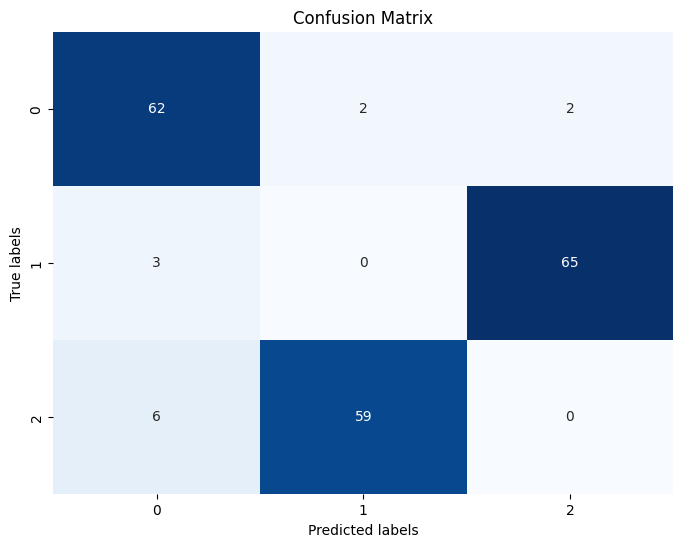

In [30]:
cluster_labelsF = np.argmax(u_fcm, axis=0)
# Step 3: Evaluate Clustering Performance
precision = precision_score(y_true, cluster_labelsF, average='weighted')
recall = recall_score(y_true, cluster_labelsF, average='weighted')
f1 = f1_score(y_true, cluster_labelsF, average='weighted')
conf_matrix = confusion_matrix(y_true, cluster_labelsF)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

As seen there are 3 clusters formed but not all cluster_labels match the original labels

**NOW lets do the same with Entropy_based_fuzzy_clustering**


In [34]:
# Define hyperparameter values to experiment with
n_clusters = 3
m_values = [1.1, 1.5, 2]  # Fuzziness parameter

# Perform Fuzzy C-Means (FCM) with entropy regularization
for m in m_values:
    # Run FCM clustering
    cntr, u, _, _, _, _, _ = cmeans(data=X2.T, c=n_clusters, m=m, error=1e-5, maxiter=1000)

    # Calculate entropy
    entropy = -np.sum(u * np.log(u))

    # Evaluate clustering performance
    silhouette_fcm = silhouette_score(df_new2, np.argmax(u, axis=0))
    print(f"FCM with Entropy Regularization (m={m}): Silhouette Score = {silhouette_fcm:.4f}, Entropy = {entropy:.4f}")

FCM with Entropy Regularization (m=1.1): Silhouette Score = 0.4173, Entropy = 6.0806
FCM with Entropy Regularization (m=1.5): Silhouette Score = 0.4173, Entropy = 59.5348
FCM with Entropy Regularization (m=2): Silhouette Score = 0.4205, Entropy = 133.2858


Entropy value is very high and increase as we increase m which is not good

In [35]:
# Define hyperparameter values to experiment with
n_clusters = 3
m_values = [1.1, 1.5, 2]  # Fuzziness parameter

# Perform Fuzzy C-Means (FCM) with entropy regularization
for m in m_values:
    # Run FCM clustering
    cntr, u, _, _, _, _, _ = cmeans(data=X.T, c=n_clusters, m=m, error=1e-5, maxiter=1000)

    # Calculate entropy
    entropy = -np.sum(u * np.log(u))

    # Evaluate clustering performance
    silhouette_fcm = silhouette_score(df_new2, np.argmax(u, axis=0))
    print(f"FCM with Entropy Regularization (m={m}): Silhouette Score = {silhouette_fcm:.4f}, Entropy = {entropy:.4f}")

FCM with Entropy Regularization (m=1.1): Silhouette Score = 0.4394, Entropy = 9.4877
FCM with Entropy Regularization (m=1.5): Silhouette Score = 0.4453, Entropy = 53.5355
FCM with Entropy Regularization (m=2): Silhouette Score = 0.4445, Entropy = 122.2730


In [36]:
# Define hyperparameter values to experiment with
n_clusters = 3
m_values = [1.1, 1.5, 2]  # Fuzziness parameter

# Perform Fuzzy C-Means (FCM) with entropy regularization
for m in m_values:
    # Run FCM clustering
    cntr, u, _, _, _, _, _ = cmeans(data=df_compressed2.T, c=n_clusters, m=m, error=1e-5, maxiter=1000)

    # Calculate entropy
    entropy = -np.sum(u * np.log(u))

    # Evaluate clustering performance
    silhouette_fcm = silhouette_score(df_compressed2, np.argmax(u, axis=0))
    print(f"FCM with Entropy Regularization (m={m}): Silhouette Score = {silhouette_fcm:.4f}, Entropy = {entropy:.4f}")

FCM with Entropy Regularization (m=1.1): Silhouette Score = 0.4046, Entropy = 9.4743
FCM with Entropy Regularization (m=1.5): Silhouette Score = 0.4016, Entropy = 53.4220
FCM with Entropy Regularization (m=2): Silhouette Score = 0.4004, Entropy = 122.0579


In [38]:
# Define hyperparameter values to experiment with
n_clusters = 3
m = 1.1  # Fuzziness parameter

# Perform Fuzzy C-Means (FCM) with entropy regularization

# Run FCM clustering
cntr, u, _, _, _, _, _ = cmeans(data=df_compressed2.T, c=n_clusters, m=m, error=1e-5, maxiter=1000)

# Calculate entropy
entropy = -np.sum(u * np.log(u))

# Evaluate clustering performance
silhouette_fcm = silhouette_score(df_compressed2, np.argmax(u, axis=0))
print(f"FCM with Entropy Regularization (m={m}): Silhouette Score = {silhouette_fcm:.4f}, Entropy = {entropy:.4f}")

FCM with Entropy Regularization (m=1.1): Silhouette Score = 0.4046, Entropy = 9.4743


Precision: 0.9370492689932118
Recall: 0.9346733668341709
F1-score: 0.9351342896073851
Confusion Matrix:
 [[62  2  2]
 [ 3 65  0]
 [ 6  0 59]]


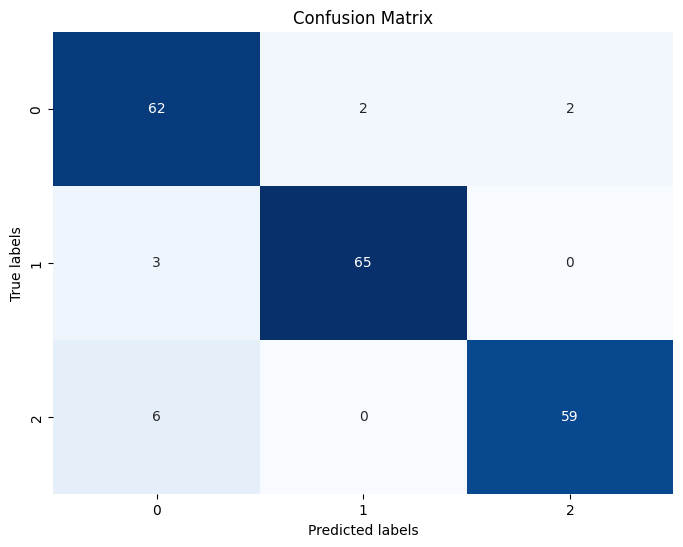

In [39]:
# Extract cluster labels
cluster_labelsFF = np.argmax(u, axis=0)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, cluster_labelsFF, average='weighted')
recall = recall_score(y_true, cluster_labelsFF, average='weighted')
f1 = f1_score(y_true, cluster_labelsFF, average='weighted')

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, cluster_labelsFF)

# Print precision, recall, F1-score, and confusion matrix
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

We were lucky enough that the expected labels mathced the correct labels😂

# **Bouns: K_Means and Hierarchical Clustering**

In [40]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

# Step 2: Hierarchical Clustering
n_clusters = 3  # Choose the number of clusters
hierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters)
cluster_labelsH = hierarchical_clustering.fit_predict(X)
# Perform K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labelsK = kmeans.fit_predict(X)

# Calculate silhouette score Hierarchical
silhouette_avg = silhouette_score(X, cluster_labelsH)
print("Silhouette Score (Hierarchical Clustering with Standard Scaling):", silhouette_avg)
# Calculate silhouette score K-means
silhouette_avg = silhouette_score(X, cluster_labelsK)
print("Silhouette Score (K_Means Clustering with Standard Scaling):", silhouette_avg)

Silhouette Score (Hierarchical Clustering with Standard Scaling): 0.39620888791074194
Silhouette Score (K_Means Clustering with Standard Scaling): 0.4043845826686474


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


**Lastly, Get the F1_score, precision, recall and confusion matrix**

Precision: 0.04708324229844877
Recall: 0.05025125628140704
F1-score: 0.04861343755816118
Confusion Matrix:
 [[ 3  2 61]
 [66  0  2]
 [ 0 58  7]]


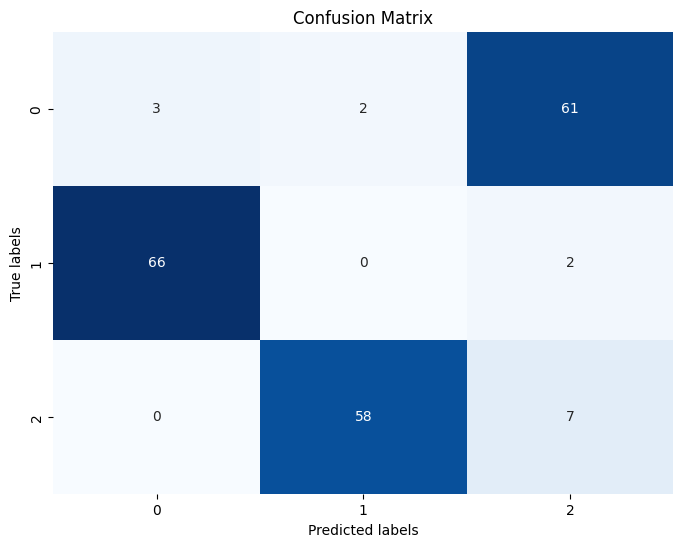

In [41]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Remove Labels
X_unlabeled = X.copy()  # Copy the standardized dataset without labels

# Step 3: Evaluate Clustering Performance
precision = precision_score(y_true, cluster_labelsK, average='weighted')
recall = recall_score(y_true, cluster_labelsK, average='weighted')
f1 = f1_score(y_true, cluster_labelsK, average='weighted')
conf_matrix = confusion_matrix(y_true, cluster_labelsK)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

**Another method of the entropy based fuzzy clustering**

In [42]:
def calculate_membership(data, centroids, m):
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    distances[distances == 0] = np.finfo(float).eps  # Avoid division by zero
    membership = 1 / np.power(distances, 2 / (m - 1))
    return membership / np.sum(membership, axis=1)[:, np.newaxis]

def calculate_centroids(data, membership, m):
    return np.dot(np.power(membership.T, m), data) / np.sum(np.power(membership.T, m), axis=1)[:, np.newaxis]

def calculate_entropy(membership):
    entropy = -np.sum(membership * np.log(membership), axis=1)
    return np.mean(entropy)

def fuzzy_c_means(data, k, m, max_iter=100, epsilon=1e-6):
    n, d = data.shape
    centroids = data[np.random.choice(n, k, replace=False)]

    for _ in range(max_iter):
        old_centroids = centroids.copy()

        membership = calculate_membership(data, centroids, m)
        centroids = calculate_centroids(data, membership, m)

        if np.linalg.norm(centroids - old_centroids) < epsilon:
            break

    entropy = calculate_entropy(membership)
    # Calculate silhouette score
    labels = np.argmax(membership, axis=1)
    silhouette = silhouette_score(data, labels)

    return centroids, membership, entropy, silhouette, labels

In [43]:
# Set parameters
k = 3  # Number of clusters
m = 2  # Fuzziness parameter
max_iter = 100  # Maximum number of iterations

# Perform fuzzy clustering
centroids, membership, entropy, silhouette, labels = fuzzy_c_means(df_compressed2, k, m, max_iter)

print("Centroids:\n", centroids)
print("\nMembership matrix shape:", membership.shape)
print("\nEntropy:", entropy)
print("\nsilhouette:", silhouette)

Centroids:
 [[ 2.83287139 -0.33581941 -0.05769843 -0.05130584  0.02257855]
 [-2.32792371 -0.63031776 -0.04551171 -0.06065894  0.02201713]
 [-0.35012693  0.96698223  0.00853153  0.10699337 -0.04294646]]

Membership matrix shape: (199, 3)

Entropy: 0.6133561012271954

silhouette: 0.4003998697235964


In [44]:
# Set parameters
k = 3  # Number of clusters
m = 1.5  # Fuzziness parameter
max_iter = 100  # Maximum number of iterations

# Perform fuzzy clustering
centroids, membership, entropy, silhouette, labels = fuzzy_c_means(df_compressed2, k, m, max_iter)

print("Centroids:\n", centroids)
print("\nMembership matrix shape:", membership.shape)
print("\nEntropy:", entropy)
print("\nsilhouette:", silhouette)

Centroids:
 [[-2.35942276 -0.66313649 -0.0349572  -0.0576564   0.02150785]
 [-0.37158154  1.05093705  0.01852625  0.1145937  -0.04233887]
 [ 2.78807416 -0.38125038 -0.02953946 -0.05240903  0.02217975]]

Membership matrix shape: (199, 3)

Entropy: 0.26845207053380593

silhouette: 0.40155806577999736


I guess this value of entropy is better than the above high values

Precision: 0.040501012525313136
Recall: 0.04020100502512563
F1-score: 0.0403498976363298
Confusion Matrix:
 [[ 4 60  2]
 [ 0  4 64]
 [62  3  0]]


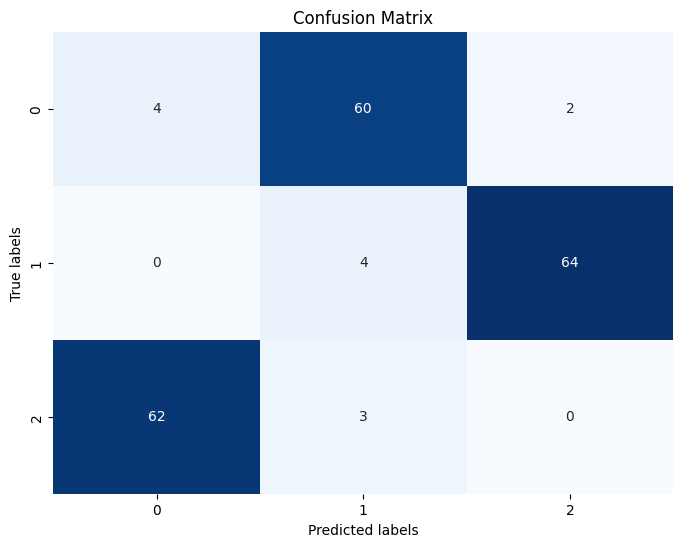

In [46]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_true, labels, average='weighted')
recall = recall_score(y_true, labels, average='weighted')
f1 = f1_score(y_true, labels, average='weighted')

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, labels)

# Print precision, recall, F1-score, and confusion matrix
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()